# Non-Deterministic case: DeePC vs. MPC based on multi-step model

Comparing the closed-loop cost and computation time.

This notebook is used to create the results for **Table 1** in our paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as sio
from casadi import *
from casadi.tools import *
import time

In [2]:
# Random seed:
np.random.seed(1234)

In [3]:
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['axes.unicode_minus'] = 'true'
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['xtick.labelsize'] = 'large'
mpl.rcParams['ytick.labelsize'] = 'large'
mpl.rcParams['axes.labelpad'] = 6

##  System description


We  now introduce the following linear system subject to zero-mean Gaussian noise $w_k\sim \mathcal{N}(0,\sigma_w^2 I)$:

\begin{align}
x_{k+1} &= Ax_k + Bu_k\\
y_k &= Cx_k+Du_k+w_k,
\end{align}

with $x \in \mathbb{R}^n$ (states), $u\in \mathbb{R}^m$ (inputs), $y\in \mathbb{R}^p$ (measurements) and system matrices $A \in \mathbb{R}^{n\times n}$, $B \in \mathbb{R}^{n\times m}$, $C \in \mathbb{R}^{p\times n}$ and $D \in \mathbb{R}^{p\times m}$.

The investigated system, displayed below, is a triple-mass-spring system (rotating discs) with two stepper motors ($m=2$) attached to the outermost discs via additional springs. These disc angles are the measured output of the system ($p=3$). The system has a total of $n=8$ states.

<img src="sources/triple_mass_spring.pdf" width=40%/>

To simulate the system, we created a very simple helper class, that keeps the current state and stores the past sequences of inputs, states and outputs.

We import the system class with:

In [4]:
import sys
# Add subfolder sources to path.
sys.path.append('./sources')
# Import class 'System' from file System.py
from System import System, random_u

In contrast to our notebook ``res_01_woNoise.ipynb`` we also import here the helper function ``random_u`` to stimulate the system with an PRBS-like input.

Import system matrices, $A,B,C,D$ and create instance of ``System``:

In [5]:
sys_dc = sio.loadmat('./sources/sys_dc.mat')
A = sys_dc['A_dc']
B = sys_dc['B_dc']
C = sys_dc['C']
D = sys_dc['D']

sys = System(A,B,C,D)

# DeePC vs. MPC based on multi-step model

## Data collection

Both methods require a measured system response for persistantly exciting input data, depending on the parameters:
$T_{\text{ini}}$ and $N$.
The total number of measured sequences depends on these parameters and must exceed the thresholds given by Assumption 1 and 2 in the paper. 

We first set the fixed parameters. **Note that we also set $\sigma_w$, the standard deviation of $w$**.

In [6]:
T_ini = 4
N = 40

L = T_ini + N

n_u = sys.n_u
n_y = sys.n_y

sig_w = 1e-2

Create matrices $U_L$ and $Y_L$ according to (2) in the paper. Note that we construct the data matrices which are neither Hankel nor Page matrices. Instead we "measure" independent sequences each with **random initial state**.

In contrast to our notebook ``res_01_woNoise`` we define here a function to obtain these matrices in dependence of the parameter ``T`` (number of sequences) and ``sig_w``.

In [7]:
def get_data_matrices(T, sig_w):
    U_L = []
    Y_L = []
    
    sys = System(A,B,C,D)

    u0 = np.zeros((2,1))

    for k in range(T):
        x0 = np.random.randn(8,1)
        sys.reset(x0)


        for k in range(L):
            u0 = random_u(u0)
            sys.make_step(u0)

        U_L.append(sys.u.reshape(-1,1))
        Y_L.append(sys.y.reshape(-1,1))

    U_L = np.concatenate(U_L,axis=1)
    Y_L = np.concatenate(Y_L,axis=1)

    # Add noise to Data:
    Y_L = Y_L+np.random.randn(*Y_L.shape)*sig_w

    assert np.linalg.matrix_rank(U_L) == U_L.shape[0], "not persistantly exciting."
    
    return U_L, Y_L

## Multi-step ahead prediction MPC

We now define functions that return the configured optimal control problems for DeePC and MPC based on a multi-step prediction model.

These functions depend on $U_L$ and $Y_L$.

In [8]:
def setup_MPC(U_L, Y_L):
    # Sys ID:
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    
    M = np.concatenate((U_Tini, U_N, Y_Tini))

    P = Y_N@np.linalg.pinv(M)
    
    # Create optimization variables:
    opt_x = struct_symMX([
        entry('y_N', shape=(n_y), repeat=N),
        entry('u_N', shape=(n_u), repeat=N),
    ])

    # Create parameters of the optimization problem
    opt_p = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
    ])

    # Create numerical instances of the structures (holding all zeros as entries)
    opt_x_num = opt_x(0)
    opt_p_num = opt_p(0)
    
    # Create the objective:
    obj = 0
    for k in range(N):
        obj += sum1(opt_x['y_N',k]**2)+0.1*sum1(opt_x['u_N', k]**2)


    # Create the constraints:
    b = vertcat(*opt_p['u_Tini'], *opt_x['u_N'], *opt_p['y_Tini'])
    y_N = vertcat(*opt_x['y_N'])
    cons = P@b-y_N


    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx = opt_x(-np.inf)
    ubx = opt_x(np.inf)

    # Set only bounds on u_N
    lbx['u_N'] = -0.7
    ubx['u_N'] = 0.7


    # Create Optim
    nlp = {'x':opt_x, 'f':obj, 'g':cons, 'p':opt_p}
    S_msm = nlpsol('S', 'ipopt', nlp)
    
    return S_msm, opt_x_num, opt_p_num, lbx, ubx

## DeePC problem

For the non-deterministic case we implement the adapted DeePC problem:

\begin{equation}
	\begin{aligned}
	\min_{g,u_N, y_N, \sigma_{y_{T_{\text{ini}}}}}\quad &\sum_{k=1}^N \left(\|y_k\|^2_{Q}+\|u_k\|^2_{R}\right)+\lambda_g \|g\|_2^2+\lambda_{\sigma_y}\|\sigma_{y}\|_2^2 \\
	\text{s.t.}\quad & 
	\left[\begin{array}{c}
	U_{T_\text{ini}}\\
	U_{N}\\
	\tilde Y_{T_\text{ini}}\\
	\tilde Y_N
	\end{array}\right] g 
	= 
	\left[\begin{array}{c}
	u_{T_\text{ini}}\\
	u_{N}\\
	y_{T_\text{ini}}\\
	y_N
	\end{array}\right]
	+
	\left[\begin{array}{c}
	0\\
	0\\
	\sigma_{y}\\
	0
	\end{array}\right]
	,\\
	&u_k \in \mathbb{U}\ \forall k\in\{1,\dots,N\},	\\
	&y_k \in \mathbb{Y}\ \forall k\in\{1,\dots,N\}. \\
	\end{aligned}
\end{equation}

Also note that the optimizer is configured such that the parameter $\lambda_g$ can be set later. 

In [9]:
def setup_DeePC(U_L, Y_L, T):
    # Configure data
    U_Tini, U_N = np.split(U_L, [n_u*T_ini],axis=0)
    Y_Tini, Y_N = np.split(Y_L, [n_y*T_ini],axis=0)
    
    # Define optim variables
    opt_x_dpc = struct_symMX([
    entry('g', shape=(T)),
    entry('u_N', shape=(n_u), repeat=N),
    entry('y_N', shape=(n_y), repeat=N),
    entry('sig_y', shape=(T_ini*(n_y))),
    ])

    opt_p_dpc = struct_symMX([
        entry('u_Tini', shape=(n_u), repeat=T_ini),
        entry('y_Tini', shape=(n_y), repeat=T_ini),
        entry('lam_g'),
    ])

    opt_x_num_dpc = opt_x_dpc(0)
    opt_p_num_dpc = opt_p_dpc(0)
    

    obj = 0
    for k in range(N):
        obj += sum1(opt_x_dpc['y_N',k]**2)+0.1*sum1(opt_x_dpc['u_N', k]**2)
    
    obj += 1e4*sum1(opt_x_dpc['sig_y']**2)
    
    obj += opt_p_dpc['lam_g']*sum1(opt_x_dpc['g']**2)


    # Create the constraints
    A = vertcat(U_Tini, U_N, Y_Tini, Y_N)
    dy_Tini = vertcat(*opt_p_dpc['y_Tini'])+opt_x_dpc['sig_y'] # Slack variable for y.
    b = vertcat(*opt_p_dpc['u_Tini'], *opt_x_dpc['u_N'], dy_Tini, *opt_x_dpc['y_N'])

    cons = A@opt_x_dpc['g']-b
    
    

    # Create lower and upper bound structures and set all values to plus/minus infinity.
    lbx_dpc = opt_x_dpc(-np.inf)
    ubx_dpc = opt_x_dpc(np.inf)


    # Set only bounds on u_N
    lbx_dpc['u_N'] = -0.7
    ubx_dpc['u_N'] = 0.7

    # Create Optim
    nlp = {'x':opt_x_dpc, 'f':obj, 'g':cons, 'p':opt_p_dpc}
    S_dpc = nlpsol('S', 'ipopt', nlp)
    
    return S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx_dpc, ubx_dpc
    

# Closed-loop comparison:

We check the closed-loop performance for $T=\{100,150,200\}$ and choose ``N_sim=60`` (number of closed-loop steps). Furthermore, every run is repeated ``N_exp=10`` times to compute average performances and computation times. 

In [10]:
T_arr = [100, 150, 200]
N_sim = 60
N_exp = 10

### DeePC

For every choosen $T$, we repeat ``N_sim`` times the following procedure:

1. Set the random seed such that the input sequence is always identical.
2. Stimulate the system with the (pseudo) random sequence. 
3. Obtain the initial condition of the system ($u_{T_{\text{ini}}},\ y_{T_{\text{ini}}}$). These are always the same.
4. Restore randomness (otherwise the experiments would be identical)
5. Get data matrices $U_L$ and $Y_L$ for the choosen value of $T$.
6. Get **DeePC optimizer** for these data matrices
7. Run the control-loop with noise on the measured output.

In [17]:
%%capture
res_deePC = []
for T in T_arr:
        
    # Repeat experiment 10 times.
    res = []
    for i in range(N_exp):
        np.random.seed(12)
        sys.reset(x0=np.zeros((8,1)))
        # Excitement
        n_exc = 20
        u0 = np.zeros((2,1))
        for k in range(n_exc):
            u0 = random_u(u0)
            sys.make_step(u0)
        
        for p in range(i):
            # Restore randomness.
            np.random.randn()

        U_L, Y_L = get_data_matrices(T, sig_w)

        S_dpc, opt_x_num_dpc, opt_p_num_dpc, lbx, ubx = setup_DeePC(U_L,Y_L,T)
        
        opt_p_num_dpc['lam_g'] = 1

        cost = []
        t_calc = []
        for k in range(N_sim):

            y_Tini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
            u_Tini = sys.u[-T_ini:,:]

            opt_p_num_dpc['y_Tini'] = vertsplit(y_Tini)
            opt_p_num_dpc['u_Tini'] = vertsplit(u_Tini)

            tic = time.time()
            r = S_dpc(p=opt_p_num_dpc, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
            toc = time.time()

            opt_x_num_dpc.master = r['x']    
        
            u0 = opt_x_num_dpc['u_N',0].full().reshape(-1,1)
            y0 = sys.make_step(u0)

            cost.append(.1*u0.T@u0+y0.T@y0)
            t_calc.append(toc-tic)


        res.append({'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost': np.concatenate(cost),'t_calc': np.array(t_calc)})
        
    res_deePC.append(res)

### MPC
For every choosen $T$, we repeat ``N_sim`` times the following procedure:

1. Set the random seed such that the input sequence is always identical.
2. Stimulate the system with the (pseudo) random sequence. 
3. Obtain the initial condition of the system ($u_{T_{\text{ini}}},\ y_{T_{\text{ini}}}$). These are always the same.
4. Restore randomness (otherwise the experiments would be identical)
5. Get data matrices $U_L$ and $Y_L$ for the choosen value of $T$.
6. Get **MPC based on multi-step prediction model** optimizer for these data matrices (with system identification)
7. Run the control-loop with noise on the measured output.

In [12]:
%%capture
res_MPC = []
for T in T_arr:
        
    # Repeat experiment 10 times.
    res = []
    for i in range(N_exp):
        np.random.seed(12)
        sys.reset(x0=np.zeros((8,1)))
        # Excitement
        n_exc = 20
        u0 = np.zeros((2,1))
        for k in range(n_exc):
            u0 = random_u(u0)
            sys.make_step(u0)
        
        for p in range(i):
            # Restore randomness.
            np.random.randn()

        U_L, Y_L = get_data_matrices(T, sig_w)

        S_mpc, opt_x_num, opt_p_num, lbx, ubx = setup_MPC(U_L,Y_L)

        cost = []
        t_calc = []
        for k in range(N_sim):

            y_ini = sys.y[-T_ini:,:]+sig_w*np.random.randn(T_ini,n_y)
            u_ini = sys.u[-T_ini:,:]

            opt_p_num['y_Tini'] = vertsplit(y_ini)
            opt_p_num['u_Tini'] = vertsplit(u_ini)

            tic = time.time()
            r = S_mpc(p=opt_p_num, lbg=0, ubg=0, lbx=lbx, ubx=ubx)
            toc = time.time()

            opt_x_num.master = r['x']  

            u0 = opt_x_num['u_N',0].full().reshape(-1,1)
            y0 = sys.make_step(u0)

            cost.append(.1*u0.T@u0+y0.T@y0)
            t_calc.append(toc-tic)


        res.append({'time':sys.time[n_exc:], 'u':sys.u[n_exc:], 'y':sys.y[n_exc:], 'cost': np.concatenate(cost),'t_calc': np.array(t_calc)})
        
    res_MPC.append(res)

In [18]:
result_summary_MPC= {'mean_cost':[],'std_cost':[], 'mean_t_calc':[], 'std_t_calc':[]}

for res_i in res_MPC:
    cost = [np.sum(res_ik['cost']) for res_ik in res_i]
    t_calc = [np.mean(res_ik['t_calc']) for res_ik in res_i]
    result_summary_MPC['mean_cost'].append(np.round(np.mean(cost),3))
    result_summary_MPC['std_cost'].append(np.round(np.std(cost),3))
    result_summary_MPC['mean_t_calc'].append(np.round(np.mean(t_calc)*1e3,3))
    result_summary_MPC['std_t_calc'].append(np.round(np.std(t_calc)*1e3,3))
    
result_summary_MPC

{'mean_cost': [5.81, 5.64, 5.632],
 'std_cost': [0.07, 0.005, 0.001],
 'mean_t_calc': [17.025, 15.966, 15.724],
 'std_t_calc': [0.24, 0.161, 0.201]}

In [19]:
result_summary_deePC= {'mean_cost':[],'std_cost':[], 'mean_t_calc':[], 'std_t_calc':[]}

for res_i in res_deePC:
    cost = [np.sum(res_ik['cost']) for res_ik in res_i]
    t_calc = [np.mean(res_ik['t_calc']) for res_ik in res_i]
    result_summary_deePC['mean_cost'].append(np.round(np.mean(cost),3))
    result_summary_deePC['std_cost'].append(np.round(np.std(cost),3))
    result_summary_deePC['mean_t_calc'].append(np.round(np.mean(t_calc)*1e3,3))
    result_summary_deePC['std_t_calc'].append(np.round(np.std(t_calc)*1e3,3))
    
result_summary_deePC

{'mean_cost': [5.924, 5.674, 5.662],
 'std_cost': [0.086, 0.012, 0.006],
 'mean_t_calc': [62.297, 72.438, 93.714],
 'std_t_calc': [3.191, 3.214, 3.863]}

We can also investigate why the cost for our propsed method is lower than with DeePC in the case for $T=100$, even though **Figure 2** in the paper (open-loop prediction) suggests that DeePC with $\lambda_g=1$ works fine in that case.

Text(0.5, 1.0, 'Proposed')

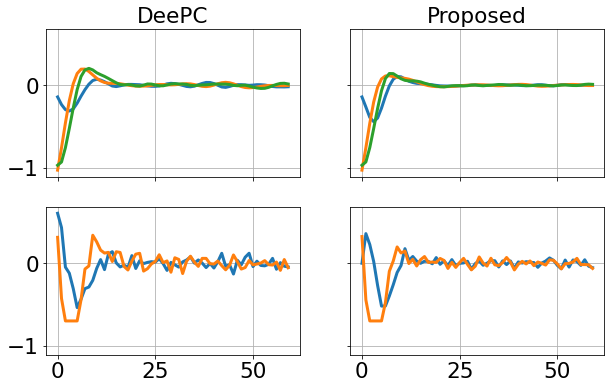

In [16]:
fig, ax = plt.subplots(2,2,sharex=True, sharey=True, figsize=(10,6))

T_plot = 0

ax[0,0].plot(res_deePC[T_plot][0]['y'])
ax[0,1].plot(res_MPC[T_plot][0]['y'])

ax[1,0].plot(res_deePC[T_plot][0]['u'])
ax[1,1].plot(res_MPC[T_plot][0]['u'])

ax[0,0].set_title('DeePC')
ax[0,1].set_title('Proposed')

We see that the problem is the oscillatory behavior around the origin, which is present in both methods but more pronounced with DeePC.